In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
# 2. Load dataset
df = pd.read_excel("Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# 3. Data Cleaning
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df.dropna(subset=['CustomerID'], inplace=True)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [4]:
# 4. RFM Analysis to create features per customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


In [5]:
# 5. Create Binary Target Variable
threshold = rfm['Monetary'].median()
rfm['SpenderClass'] = (rfm['Monetary'] > threshold).astype(int)

# 1 = High spender, 0 = Low spender
rfm[['Monetary', 'SpenderClass']].head()


,Monetary,SpenderClass
0,77183.60,1
1,4310.00,1
2,1797.24,1
3,1757.55,1
4,334.40,0


In [6]:
# 6. Prepare features and target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['SpenderClass']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.6, random_state=42
)



In [7]:
# 7. Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


Accuracy Score: 0.8962735305416827

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      1292
           1       0.94      0.85      0.89      1311

    accuracy                           0.90      2603
   macro avg       0.90      0.90      0.90      2603
weighted avg       0.90      0.90      0.90      2603



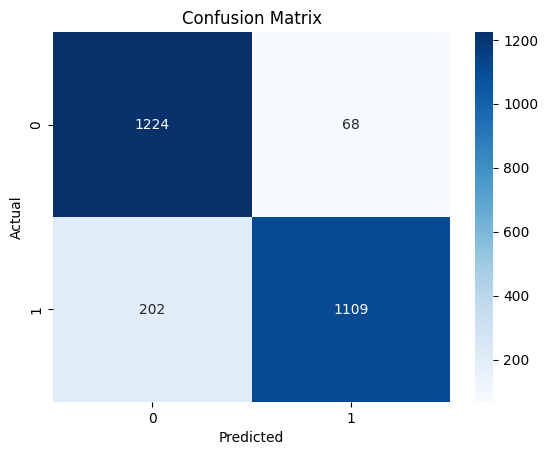

In [8]:
# 8. Evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [1]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# --- Page Configuration with Dark Mode ---
st.set_page_config(
    page_title="Customer Spender Classifier",
    page_icon="🛍️",
    layout="centered"
)

# --- Custom Style for Buttons in Dark Theme ---
st.markdown("""
    <style>
    .stButton > button {
        background-color: #1f77b4;
        color: white;
        border-radius: 10px;
        padding: 0.5em 1em;
    }
    </style>
""", unsafe_allow_html=True)

# --- Title ---
st.title("🛍️ Customer Spender Classification App")
st.markdown("Use this app to predict whether a customer is a **High Spender** or **Low Spender** based on their behavior metrics.")

# --- Load and preprocess data ---
@st.cache_data
def load_data():
    df = pd.read_excel("Online Retail.xlsx")
    df = df[df['Quantity'] > 0]
    df = df[df['UnitPrice'] > 0]
    df = df.dropna(subset=['CustomerID'])
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }).reset_index()

    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    threshold = rfm['Monetary'].median()
    rfm['SpenderClass'] = (rfm['Monetary'] > threshold).astype(int)
    return rfm

rfm = load_data()

# --- Train Model ---
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['SpenderClass']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression()
model.fit(X_train, y_train)

# --- Sidebar Visualizations ---
st.sidebar.header("📊 Data Insights")

# Spender Class Distribution
fig1, ax1 = plt.subplots()
rfm['SpenderClass'].value_counts().plot(kind='bar', color=['#66c2a5', '#fc8d62'], ax=ax1)
ax1.set_xticklabels(['Low Spender', 'High Spender'], rotation=0)
ax1.set_title("Spender Class Count")
st.sidebar.pyplot(fig1)

# Monetary Histogram
fig2, ax2 = plt.subplots()
sns.histplot(rfm['Monetary'], bins=30, kde=True, ax=ax2, color="#8da0cb")
ax2.set_title("Distribution of Monetary Value")
st.sidebar.pyplot(fig2)

# Recency by Class Boxplot
fig3, ax3 = plt.subplots()
sns.boxplot(data=rfm, x='SpenderClass', y='Recency', palette="Set2", ax=ax3)
ax3.set_xticklabels(['Low Spender', 'High Spender'])
ax3.set_title("Recency by Spender Class")
st.sidebar.pyplot(fig3)

# --- Page Navigation ---
st.markdown("### 📄 Page Navigation")
selected_page = st.radio("Choose a page:", ["Prediction", "Raw Data", "Data Summary"], horizontal=True)

# --- Page: Raw Data ---
if selected_page == "Raw Data":
    st.markdown("## 📂 Raw Dataset Preview")
    st.dataframe(rfm.head(50))

# --- Page: Data Summary ---
elif selected_page == "Data Summary":
    st.markdown("## 📊 Dataset Summary Statistics")
    st.write(rfm.describe())
    st.markdown("### 🔍 Null Values Check")
    st.write(rfm.isnull().sum())

# --- Page: Prediction Form ---
elif selected_page == "Prediction":
    with st.form("prediction_form"):
        st.markdown("### ✏️ Enter Customer Data")

        recency = st.number_input("Recency (days since last purchase):", min_value=0, value=30)
        frequency = st.number_input("Frequency (number of invoices):", min_value=0, value=5)
        monetary = st.number_input("Monetary (total spending amount):", min_value=0.0, value=500.0)

        submit = st.form_submit_button("Predict")

    if submit:
        input_data = np.array([[recency, frequency, monetary]])
        input_scaled = scaler.transform(input_data)
        prediction = model.predict(input_scaled)[0]
        prob = model.predict_proba(input_scaled)[0][prediction]

        spender_label = "🤑 High Spender" if prediction == 1 else "🙂 Low Spender"
        st.success(f"Prediction: **{spender_label}**")
        st.info(f"Model Confidence: **{prob*100:.2f}%**")

# --- Model Evaluation on Sidebar ---
y_pred_test = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
st.sidebar.markdown(f"📊 **Model Accuracy:** `{accuracy*100:.2f}%` on test data")


Overwriting app.py


In [ ]:
!streamlit run app.py